In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook
root_dir = '/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


/global/cfs/cdirs/lsst/www/shivamp/env/CS2_pm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ji = 0
ns_d = 256
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 0.5, 127]
ns_h = 128
nax_h = ns_h // nb

nsims_per_batch = 64
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 2


In [3]:
print(nbatches_train)


2


In [4]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 3
nflows_M1_NSF = 5
K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 6
base_dist_M1 = 'gumbel'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5
changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp



In [5]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data(
    ji, ns_d, nb, nf, nc, z_all, ns_h
    )

# Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




0 64
64 128


In [6]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=None
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    mu_pos=False
    )

# model_M1.to(dev)

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
# model_Mdiff.to(dev)

# print()



In [7]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()




In [8]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(2, 64, 3, 38, 38, 38)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all'])).cuda(dev)
# cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
print(cond_nsh.shape)
cond_tensor_nsh = torch.Tensor(np.array(cond_nsh).reshape(nbatches_train,nsims_per_batch * (nax_h ** 3), ninp)).cuda(dev)
mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1']).reshape(nbatches_train,nsims_per_batch * (nax_h**3))).cuda(dev)
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff))).cuda(dev)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1))).cuda(dev)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)).cuda(dev)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
                                                                                 ndim_diff)).cuda(dev)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)))).cuda(dev)






(2, 64, 16, 16, 16, 3)


In [10]:
print(X_Mdiff.shape)



torch.Size([2, 262144, 9])


In [11]:
# save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(8)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [12]:
train_Ntot, train_M1, train_Mdiff = 1, 1, 1



In [13]:
# cond_tensor.shape
# 16 * 32 * 3 * 70 * 70 * 70



In [ ]:
ninit = 0
niterations = 1000

# torch.autograd.set_detect_anomaly(False)
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    for g in optimizer.param_groups:
        g['lr'] = 0.001

    it = ito + ninit

    loss = model(
        X_Mdiff,
        X_M1,
        X_Nhalo,
        cond_x=cond_tensor,
        cond_x_nsh=cond_tensor_nsh,
        mask_Mdiff_truth_all=mask_tensor_Mdiff_train,
        mask_M1_truth_all=mask_tensor_M1_train,
        Nhalos_truth_all=Nhalos_truth_tensor,
        use_Ntot_samples=False,
        use_M1_samples=False,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff       
        )

    loss.backward()
    optimizer.step()

    if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(
                state, save_bestfit_model_name
                )


            

  0%|          | 0/1000 [00:05<?, ?it/s]


In [ ]:
# cond_tensor.shape




In [16]:
cond_tensor = cond_tensor.to(dev)
cond_tensor_nsh = cond_tensor_nsh.to(dev)
Ntot_samp, M1_samp, M_diff_samp, mask_tensor_M1_samp, mask_tensor_Mdiff_samp = model.inverse(
        cond_x=cond_tensor,
        cond_x_nsh=cond_tensor_nsh,
        use_truth_Nhalo=1-train_Ntot,
            use_truth_M1=1-train_M1,
            use_truth_Mdiff=1-train_Mdiff,    
            mask_Mdiff_truth=mask_tensor_Mdiff_train,
            mask_M1_truth=mask_tensor_M1_train,
            Nhalos_truth=X_Nhalo,
            M1_truth=X_M1,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff 
        )








In [17]:
# train_Mdiff
Nhalos_truth_tensor.shape


torch.Size([2, 262144, 1])

In [18]:
np.amin(cond_tensor_nsh.cpu().detach().numpy()[:,0])


-0.87387514

Text(0, 0.5, 'Histogram')

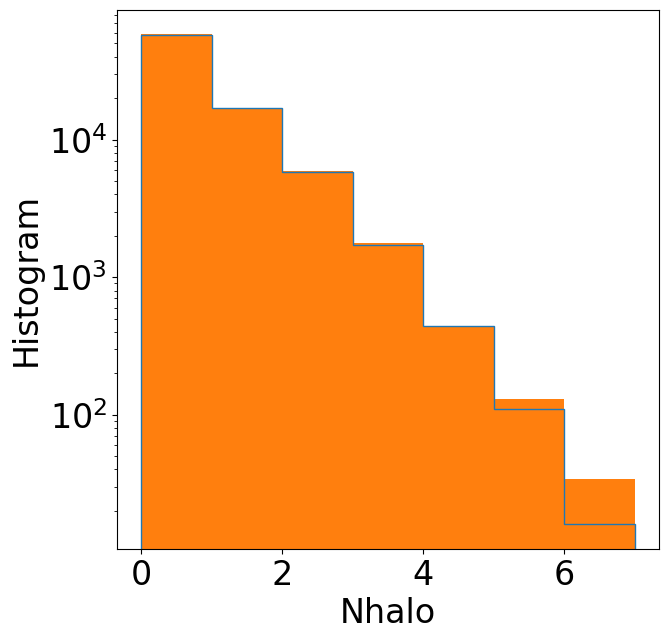

In [19]:
pl.figure()
jb = 0
indsel = np.where(cond_tensor_nsh[jb].cpu().detach().numpy()[:,0] > 0.0)
_ = pl.hist(Ntot_samp[jb][indsel], histtype='step', bins=[0,1,2,3,4,5,6,7])
_ = pl.hist(Nhalos_truth_tensor[jb].cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5,6,7])
# xarr = np.arange(9)
# yarr = 4e5*np.exp(-xarr)
# al, bt = 0.0, 1.5
# yarr = 4e5*np.power(1+xarr, al) * np.exp(-bt * xarr)
# yarr = 4e5/xarr**(5)
# pl.plot(xarr, yarr)
# _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
pl.yscale('log')
pl.xlabel('Nhalo')
pl.ylabel('Histogram')






Text(0, 0.5, 'Histogram')

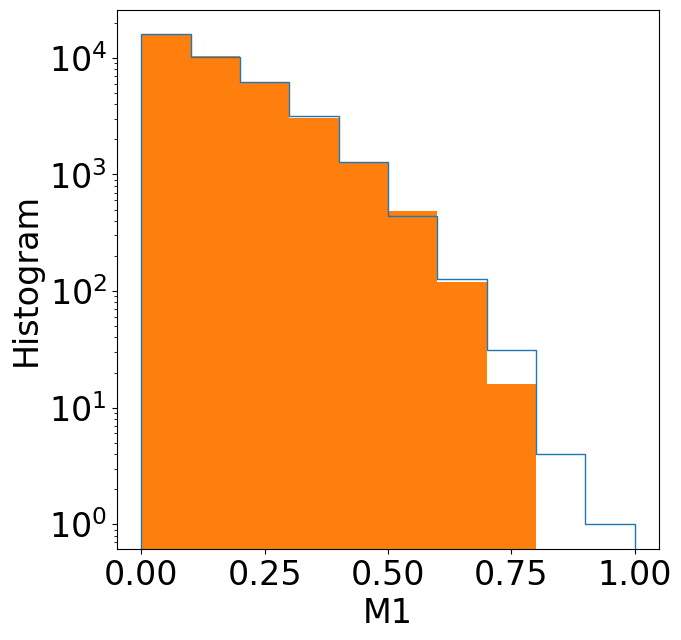

In [20]:
pl.figure()
indp = (mask_tensor_M1_samp[jb].cpu().detach().numpy()[:,0] > 0)
_ = pl.hist(M1_samp[jb].cpu().detach().numpy()[indp], range=(0,1), histtype='step')
indp = (mask_tensor_M1_train[jb].cpu().detach().numpy() > 0)
_ = pl.hist(X_M1[jb][:,0].cpu().detach().numpy()[indp], range=(0,1))
pl.yscale('log')
pl.xlabel('M1')
pl.ylabel('Histogram')








Text(0, 0.5, 'Histogram')

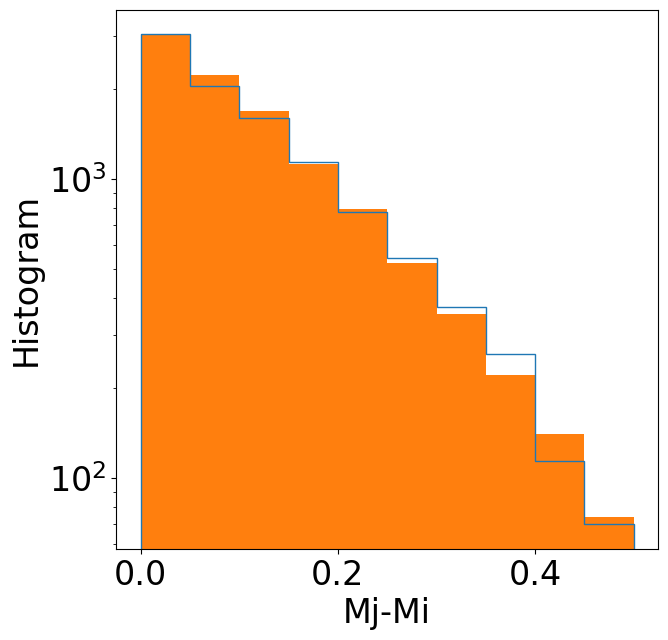

In [21]:
pl.figure()
ind_M = 0

indp = mask_tensor_Mdiff_samp[jb][:, ind_M] > 0
_ = pl.hist(M_diff_samp[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5), histtype='step')
indp = mask_tensor_Mdiff_train[jb][:, ind_M] > 0
_ = pl.hist(X_Mdiff[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5))


pl.yscale('log')
pl.xlabel(r'Mj-Mi')
pl.ylabel('Histogram')






In [22]:
# now we load the test data
nstart = 0
nsims_test = 64
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data(
    1, ns_d, nb, nf, nc, z_all, ns_h
    )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
nscount = 0
for jq in range(nq):
    # Load the density data

    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        )

    cond_tensor_test = torch.Tensor(np.copy(return_dict_test['df_d_all'])).cuda(dev)
    cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    # cond_tensor_nsh_test = torch.Tensor(
    #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
    #     ).cuda(dev)
    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)

    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=False,
        use_truth_M1=False,
        use_truth_Mdiff=False,
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff         
        )
    Ntot_samp_test = Ntot_samp_test[:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                   ...] = (M1_samp_test * mask_tensor_M1_samp_test[:, 0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_Mdiff[nscount:nscount + nsims_test,
                      ...] = (M_diff_samp_test * mask_tensor_Mdiff_samp_test
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_samp_test[:,
                                                   0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    nscount += nsims_test
    
    
    

0 64


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5